In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LinUCB:
    def __init__(self, T, d, k, alpha, theta):
        self.time_horizon = T
        self.context_dim = d
        self.arm_count = k
        self.alpha = alpha
        self.theta = theta
        self.A = np.zeros((self.arm_count, self.context_dim, self.context_dim)) + np.eye(self.context_dim)
        self.A_inverse = np.zeros_like(self.A)
        self.b = np.zeros((self.arm_count, self.context_dim, 1))
        self.theta_hat = np.zeros((self.arm_count, self.context_dim, 1))
        self.p_curr = np.zeros(self.arm_count)
        self.total_reward = 0
        self.arm_sample_count = np.zeros(self.arm_count)
        self.reward_history = []
        self.regret_history = []
        
    def update(self, arm, context, reward):
        self.A[arm] += np.dot(context, context.T)
        self.b[arm] += reward*context
    
    def play(self):
        for t in range(self.time_horizon):
            contexts = np.random.normal(loc=0.0, scale=1.0, size=(self.arm_count, self.context_dim, 1))
            for a in range(self.arm_count):
                contexts[a] = np.random.uniform(0.0, 1.0)*contexts[a]/np.linalg.norm(contexts[a])    # L2 norm between 0 and 1
                self.A_inverse[a] = np.linalg.inv(self.A[a])
            for a in range(self.arm_count):
                self.theta_hat[a] = np.dot(self.A_inverse[a],self.b[a])
                self.p_curr[a] = float(np.dot(self.theta_hat[a].T, contexts[a]) + self.alpha*np.sqrt(np.dot(np.dot(contexts[a].T, self.A_inverse[a]), contexts[a])))
            curr_arm = np.argmax(self.p_curr)
            curr_reward = np.random.normal(loc=float(np.dot(self.theta[curr_arm].T, contexts[curr_arm])), scale=0.01)
            self.update(curr_arm, contexts[curr_arm], curr_reward)
            self.total_reward += curr_reward
            self.arm_sample_count[curr_arm] += 1
            self.reward_history.append(self.total_reward)
            curr_regret = float(np.max(np.sum(np.sum(self.theta*contexts, axis=2), axis=1)) - curr_reward)
            if(len(self.regret_history)==0):
                self.regret_history.append(curr_regret)
            else:
                self.regret_history.append(self.regret_history[-1] + curr_regret)

In [3]:
d=5
k=10
T=int(1e5)
#alpha= d*np.log(T)
alpha=2.0
theta = np.random.normal(loc=0, scale=1.0, size=(k, d, 1))
for arm in range(k):
    theta[arm] = np.random.uniform(0.0,1.0)*theta[arm]/np.linalg.norm(theta[arm])
player = LinUCB(T, d, k, alpha, theta)
player.play()

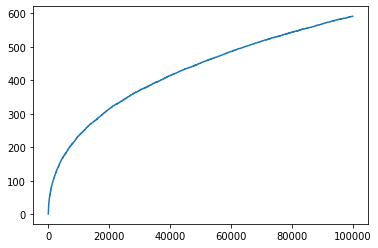

In [4]:
plt.plot(player.regret_history)

In [5]:
print(player.arm_sample_count)

[16492. 16158.  6760. 13597.  3059.  3296. 11645.  3499.  8531. 16963.]


In [6]:
for a in range(k):
    print(player.arm_sample_count[a], np.linalg.norm(theta[a]))

16492.0 0.8976324134440734
16158.0 0.8786265983148918
6760.0 0.33636184898398036
13597.0 0.7284564811573574
3059.0 0.03425525827497122
3296.0 0.08490813339096148
11645.0 0.6113562928380092
3499.0 0.11091193733686945
8531.0 0.44343873470453965
16963.0 0.9090155666664752
